In [1]:
#!/usr/bin/env python
# coding: utf-8

# Import necessary packages
import requests
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime
import re
import string
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sruja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
headers = {
    'authority': 'www.amazon.in',
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'accept-language': 'en-US,en;q=0.9,bn;q=0.8',
    'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="102", "Google Chrome";v="102"',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'
}

In [3]:
reviews_url = 'https://www.amazon.in/Ultrahuman-M1-Glucose-Monitoring-FreeStyle/product-reviews/B0BFFYCJQJ/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews'
# Number of pages to scrape
len_page = 10

In [4]:
# Function to fetch reviews HTML from multiple pages
def reviewsHtml(url, len_page):
    soups = []
    for page_no in range(1, len_page + 1):
        params = {
            'ie': 'UTF8',
            'reviewerType': 'all_reviews',
            'filterByStar': 'all_stars',
            'pageNumber': page_no,
        }
        response = requests.get(url, headers=headers, params=params)
        soup = BeautifulSoup(response.text, 'lxml')
        soups.append(soup)
    return soups

In [5]:

# Function to extract reviews data from HTML
def getReviews(html_data):
    data_dicts = []
    boxes = html_data.select('div[data-hook="review"]')
    for box in boxes:
        try:
            name = box.select_one('.a-profile-name').text.strip()
        except Exception:
            name = 'N/A'
        try:
            stars = box.select_one('[data-hook="review-star-rating"]').text.strip().split(' out')[0]
        except Exception:
            stars = 'N/A'
        try:
            title = box.select_one('[data-hook="review-title"]').text.strip()
        except Exception:
            title = 'N/A'
        try:
            datetime_str = box.select_one('[data-hook="review-date"]').text.strip().split(' on ')[-1]
            date = datetime.strptime(datetime_str, '%B %d, %Y').strftime("%d/%m/%Y")
        except Exception:
            date = 'N/A'
        try:
            description = box.select_one('[data-hook="review-body"]').text.strip()
        except Exception:
            description = 'N/A'
        data_dict = {
            'Name': name,
            'Stars': stars,
            'Title': title,
            'Date': date,
            'Description': description
        }
        data_dicts.append(data_dict)
    return data_dicts

In [6]:
# Fetch all HTML pages
html_datas = reviewsHtml(reviews_url, len_page)

# Extract reviews from all HTML pages
reviews = []
for html_data in html_datas:
    review = getReviews(html_data)
    reviews += review

# Create a dataframe with reviews data
df_reviews = pd.DataFrame(reviews)

# Save data to CSV
df_reviews.to_csv('reviewsall.csv', index=False)


In [7]:
# Clean the Description column
df_reviews['Description'] = df_reviews['Description'].str.replace('\n', ' ').str.strip()

# Define text preprocessing functions
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

def apply_stemming(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)

# Apply preprocessing steps to df_reviews['Description']
df_reviews['Cleaned_Description'] = df_reviews['Description'].apply(remove_punctuation)
df_reviews['Cleaned_Description'] = df_reviews['Cleaned_Description'].apply(remove_stopwords)
df_reviews['Cleaned_Description'] = df_reviews['Cleaned_Description'].apply(apply_stemming)




Most common words:
read: 35
product: 29
glucos: 27
app: 26
sensor: 26
ultrahuman: 21
use: 21
day: 20
level: 20
’: 16
food: 16
libr: 15
get: 14
one: 13
help: 13
tri: 12
time: 12
show: 12
good: 12
cgm: 12


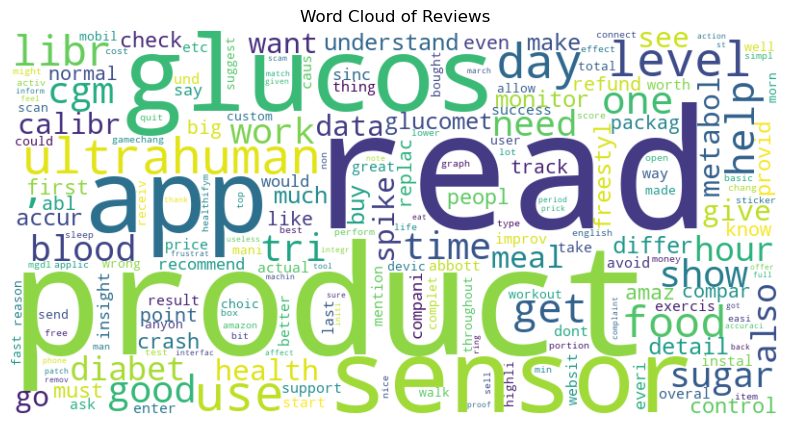

In [8]:
# Word Frequency Analysis
stop_words = set(stopwords.words('english') + list(string.punctuation))

def clean_tokenize(text):
    text = re.sub(r'\d+', '', text)  # Remove numbers
    tokens = text.lower().split()
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

all_words = df_reviews['Cleaned_Description'].apply(clean_tokenize).sum()
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(20)

print("Most common words:")
for word, freq in most_common_words:
    print(f"{word}: {freq}")
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()


Summary statistics of review lengths:
count      54.000000
mean      388.444444
std       539.943242
min        17.000000
25%       137.750000
50%       248.000000
75%       410.000000
max      3394.000000
Name: Review_Length, dtype: float64


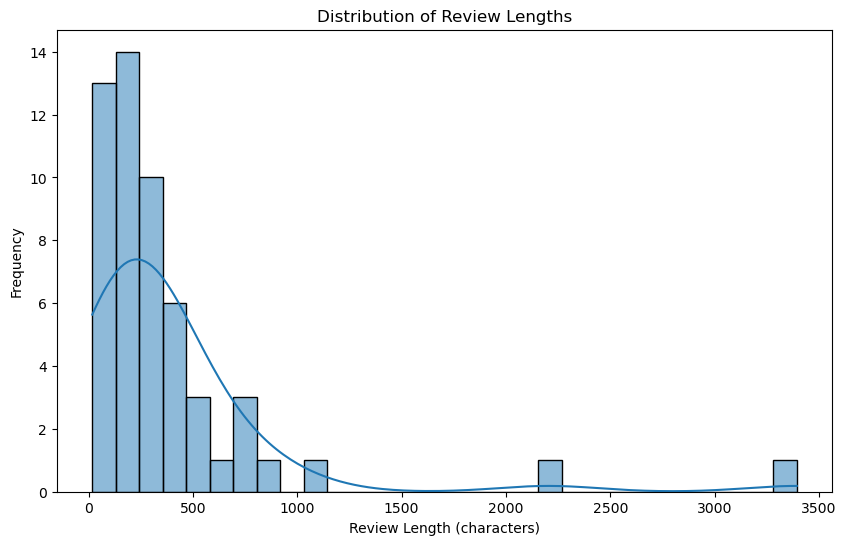

In [9]:
# Review Length Analysis
df_reviews['Review_Length'] = df_reviews['Description'].apply(len)

print("Summary statistics of review lengths:")
print(df_reviews['Review_Length'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df_reviews['Review_Length'], bins=30, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (characters)')
plt.ylabel('Frequency')
plt.show()

Top bigrams:
glucos level: 9
freestyl libr: 7
glucos spike: 5
blood sugar: 5
app read: 4
ultrahuman m1: 4
spike crash: 4
glucos read: 4
control glucos: 3
amaz product: 3
sensor work: 3
read glucos: 3
track glucos: 3
level differ: 2
meal affect: 2
read tri: 2
sugar level: 2
day complaint: 2
ultrahuman big: 2
anyon want: 2


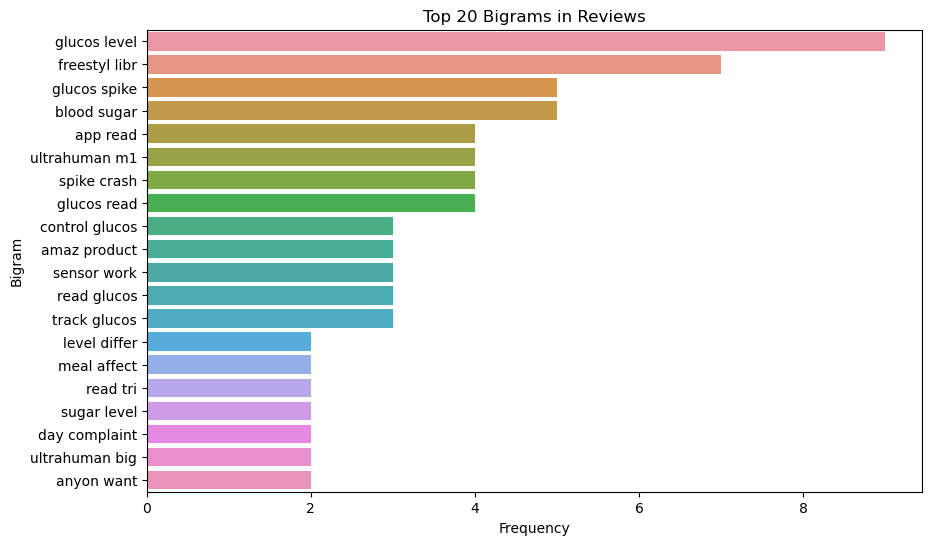

In [10]:
# Common Words and Phrases
def get_top_n_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

top_bigrams = get_top_n_bigrams(df_reviews['Cleaned_Description'], n=20)

print("Top bigrams:")
for bigram, freq in top_bigrams:
    print(f"{bigram}: {freq}")

bigrams_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frequency'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Bigram', data=bigrams_df)
plt.title('Top 20 Bigrams in Reviews')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.show()


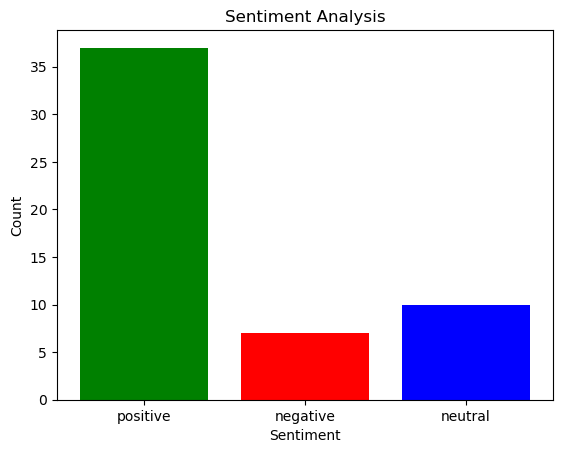

In [13]:
# Sentiment Analysis
def calculate_sentiment(text):
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity
    if sentiment_score > 0:
        return 'positive'
    elif sentiment_score < 0:
        return 'negative'
    else:
        return 'neutral'

# Calculate sentiment for each review
reviews = [i for i in df_reviews['Cleaned_Description']]
sentiment = [calculate_sentiment(review) for review in reviews]

# Count the occurrences of each sentiment
sentiment_counts = {
    'positive': sentiments.count('positive'),
    'negative': sentiments.count('negative'),
    'neutral': sentiments.count('neutral')
}

plt.bar(sentiment_counts.keys(), sentiment_counts.values(), color=['green', 'red', 'blue'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Analysis')
plt.show()

In [14]:
df_reviews['Sentiment'] = sentiments

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Assuming df_reviews is already defined and contains the cleaned reviews and sentiment
# If not, ensure df_reviews['Cleaned_Description'] and df_reviews['Sentiment'] are populated accordingly

# Encode sentiment labels
label_encoder = LabelEncoder()
df_reviews['Sentiment'] = label_encoder.fit_transform(df_reviews['Sentiment'])

# Define features and target
X = df_reviews['Cleaned_Description']
y = df_reviews['Sentiment']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Define the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Train and evaluate each model
best_model = None
best_accuracy = 0
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")

    # Get the unique labels in y_test for generating classification report
    unique_labels = np.unique(y_test)
    target_names = label_encoder.inverse_transform(unique_labels).astype(str)  # Ensure target names are strings
    print(classification_report(y_test, y_pred, labels=unique_labels, target_names=target_names, zero_division=0))
    print(confusion_matrix(y_test, y_pred, labels=unique_labels))
    print("\n")

    results[model_name] = accuracy
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model_name

print(f"The best model is {best_model} with an accuracy of {best_accuracy:.4f}")

# Output the best model's classification report and confusion matrix
best_model_instance = models[best_model]
y_pred_best = best_model_instance.predict(X_test_vec)
print(f"Classification Report for {best_model}:")
print(classification_report(y_test, y_pred_best, labels=unique_labels, target_names=target_names, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best, labels=unique_labels))


Training Logistic Regression...
Logistic Regression Accuracy: 0.9091
              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00         1
    positive       0.91      1.00      0.95        10

    accuracy                           0.91        11
   macro avg       0.45      0.50      0.48        11
weighted avg       0.83      0.91      0.87        11

[[ 0  1]
 [ 0 10]]


Training Support Vector Machine...
Support Vector Machine Accuracy: 0.9091
              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00         1
    positive       0.91      1.00      0.95        10

    accuracy                           0.91        11
   macro avg       0.45      0.50      0.48        11
weighted avg       0.83      0.91      0.87        11

[[ 0  1]
 [ 0 10]]


Training Random Forest...
Random Forest Accuracy: 0.9091
              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00     

In [20]:
#Cross Validation

from sklearn.model_selection import cross_val_score

# Define dictionaries to store classification reports and confusion matrices for each model
classification_reports = {}
confusion_matrices = {}

# Define a dictionary to store the accuracies for each model
accuracies = {}

# Define the number of iterations for cross-validation
num_iterations = 100

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Lists to store results for each iteration
    model_accuracies = []
    model_classification_reports = []
    model_confusion_matrices = []
    
    for i in range(num_iterations):
        # Split the data for cross-validation
        X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X, y, test_size=0.3, random_state=i)
        
        # Vectorize text data using TF-IDF
        X_train_vec_cv = vectorizer.fit_transform(X_train_cv)
        X_test_vec_cv = vectorizer.transform(X_test_cv)
        
        # Fit the model
        model.fit(X_train_vec_cv, y_train_cv)
        
        # Predict on test set
        y_pred_cv = model.predict(X_test_vec_cv)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test_cv, y_pred_cv)
        model_accuracies.append(accuracy)
        
        # Calculate classification report and confusion matrix
        classification_rep = classification_report(y_test_cv, y_pred_cv, zero_division=0)
        confusion_mat = confusion_matrix(y_test_cv, y_pred_cv)
        model_classification_reports.append(classification_rep)
        model_confusion_matrices.append(confusion_mat)
    
    # Store results for this model
    accuracies[model_name] = np.mean(model_accuracies)
    classification_reports[model_name] = model_classification_reports
    confusion_matrices[model_name] = model_confusion_matrices
    
    print(f"{model_name} Accuracy: {accuracies[model_name]:.4f}")
    print(classification_reports[model_name][0])  # Print the classification report for the first iteration
    print(confusion_matrices[model_name][0])       # Print the confusion matrix for the first iteration
    print("\n")

# Find the best model based on mean accuracy
best_model = max(accuracies, key=accuracies.get)
best_accuracy = accuracies[best_model]
print(f"The best model is {best_model} with an average accuracy of {best_accuracy:.4f}")

# Output the best model's classification report and confusion matrix for the first iteration
print(f"Classification Report for {best_model}:")
print(classification_reports[best_model][0])
print("Confusion Matrix:")
print(confusion_matrices[best_model][0])


Training Logistic Regression...
Logistic Regression Accuracy: 0.6712
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         5
           2       0.47      1.00      0.64         8

    accuracy                           0.47        17
   macro avg       0.16      0.33      0.21        17
weighted avg       0.22      0.47      0.30        17

[[0 0 4]
 [0 0 5]
 [0 0 8]]


Training Support Vector Machine...
Support Vector Machine Accuracy: 0.6712
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         5
           2       0.47      1.00      0.64         8

    accuracy                           0.47        17
   macro avg       0.16      0.33      0.21        17
weighted avg       0.22      0.47      0.30        17

[[0 0 4]
 [0 0 5]
 [0 0 8]]


Training Random Forest...
Random F

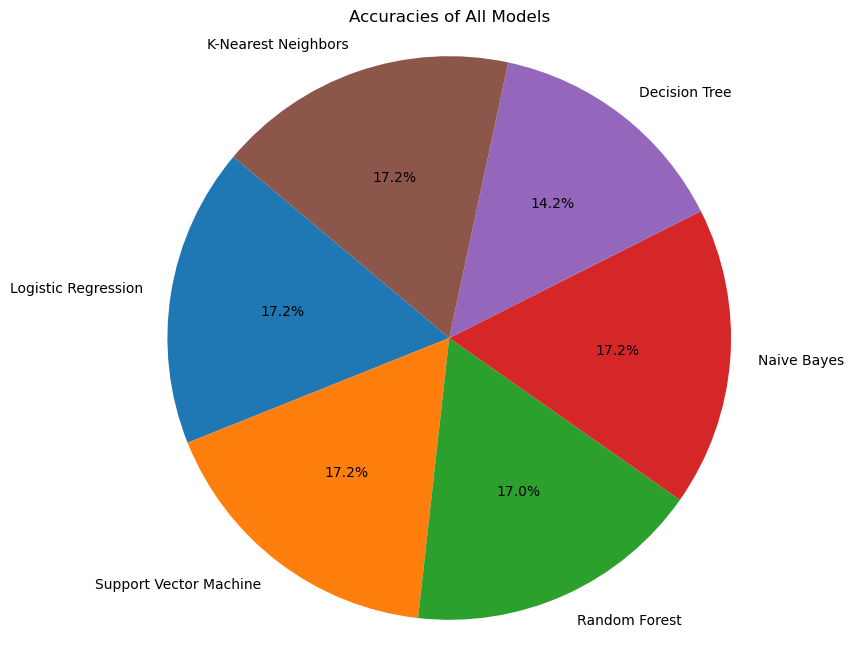

In [21]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = list(accuracies.keys())
sizes = list(accuracies.values())

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Accuracies of All Models')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


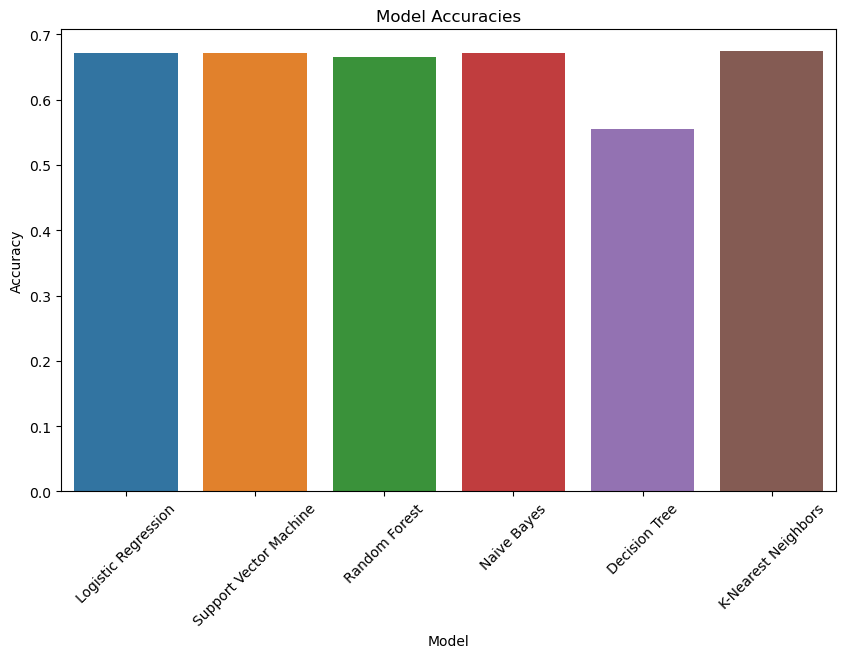

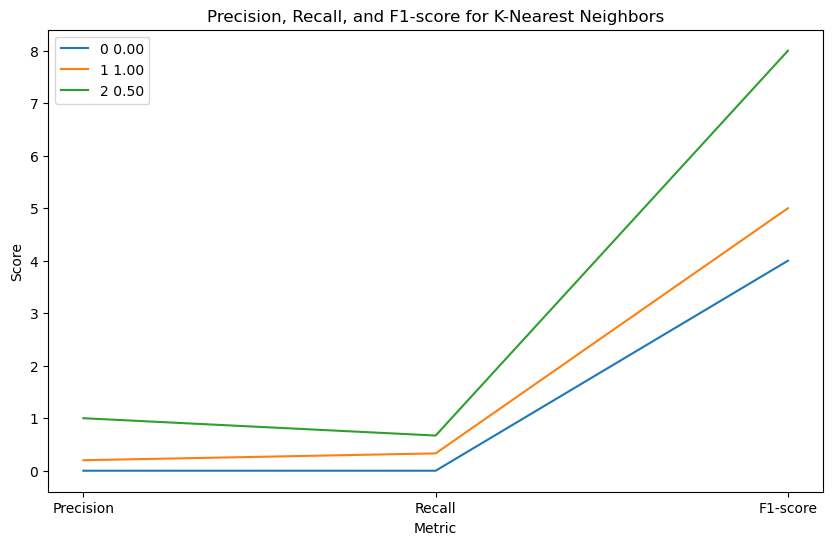

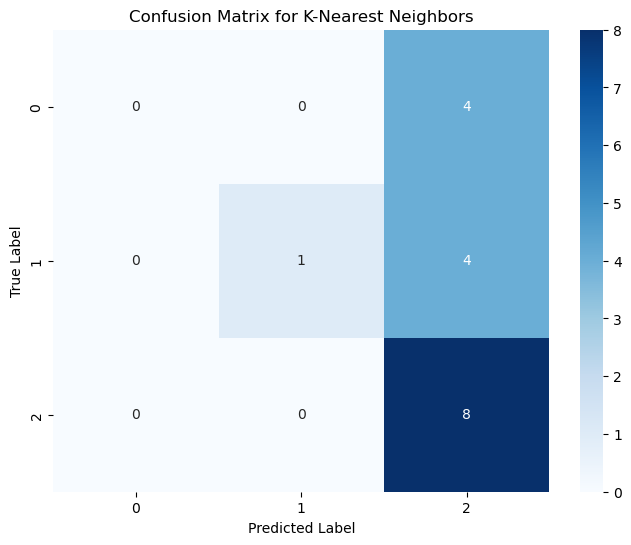

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.title('Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

# Visualize precision, recall, and F1-score for the best model
best_model_classification_report = classification_reports[best_model][0]
precision_recall_f1 = best_model_classification_report.split('\n')[2:5]

plt.figure(figsize=(10, 6))
for line in precision_recall_f1:
    metric, values = line.split()[:2], line.split()[2:]
    plt.plot(['Precision', 'Recall', 'F1-score'], [float(value) for value in values], label=f'{metric[0]} {metric[1]}')

plt.title(f'Precision, Recall, and F1-score for {best_model}')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.legend()
plt.show()


# Visualize confusion matrix for the best model
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrices[best_model][0], annot=True, cmap='Blues', fmt='g')
plt.title(f'Confusion Matrix for {best_model}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

